# Emission Measure Analysis: 2D AR Maps
Compute the emission measure in every pixel of our AR map for both the "ground truth" EM as well as the EM determined by the inversion method of Hannah and Kontar (2012)

We will do this for each of our four heating frequencies:
* $t_N=250$ s
* $t_N=750$ s
* $t_N=2500$ s
* $t_N=5000$ s

## Table of Contents
* [Ground Truth EM](#"Ground-Truth"-Emission-Measure-Distribution)
* [Regularized EM](#Inverted-Emission-Measure-Distribution)
* [EM Slope Distributions](#Compare-Slope-Distributions)
* [1D EM Distributions](#1D-EM-Distributions-for-Area-in-Warren-et-al.,-2012)

In [1]:
import os
import io
import copy
import glob
import urllib

import numpy as np
import pandas
from scipy.optimize import curve_fit
import scipy.linalg
import scipy.stats
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import hissw
from sunpy.map import Map,GenericMap
import h5py
from ChiantiPy.tools import filters as ch_filters

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube
from synthesizAR.atomic import EmissionModel

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
base = '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{}'

In [3]:
aia = InstrumentSDOAIA([7.5e3,1.25e4]*u.s)
eis = InstrumentHinodeEIS([7.5e3,1.25e4]*u.s)

In [476]:
temperature_bin_edges = 10.**(np.arange(5.6, 7.0, 0.05))*u.K

In [14]:
left_x = 350*u.arcsec
bottom_y = 265*u.arcsec
width = 20*u.arcsec
height = 15*u.arcsec
right_x = left_x + width
top_y = bottom_y + height

## "Ground Truth" Emission Measure Distribution
We want to compute the *time-averaged* EM distribution so we need to first construct the $(x,y,T)$ cube at each timestep, add them, and then average. This is fairly straightforward, but if we load everything into memory it is going to take forever.

In [15]:
frequencies = [250,750,2500,5000]

### Time Averages

Setup a few datacubes to hold the averaged data. We'll bin at the EIS resolution to lower the memory footprint of these arrays.

In [50]:
average_ems_raw = {freq:None for freq in frequencies}

Iterate over the frequencies. We need to setup a field and observer object for each frequency. Then, we iterate in time.

In [51]:
for freq in frequencies:
    print('tn = {} s'.format(freq))
    # setup field and observer objects
    field = synthesizAR.Skeleton.restore(os.path.join(base.format(freq),'field_checkpoint'))
    observer = synthesizAR.Observer(field,[eis],ds=field._convert_angle_to_length(0.4*u.arcsec))
    observer.build_detector_files(base.format(freq))
    # iterate over time
    for time in eis.observing_time:
        print('t = {}'.format(time))
        emcube = observer.make_emission_measure_map(time,eis,temperature_bin_edges=temperature_bin_edges)
        if average_ems_raw[freq] is None:
            average_ems_raw[freq] = emcube.as_array()
        else:
            average_ems_raw[freq] += emcube.as_array()

tn = 250 s


No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-13 18:00:52,783 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-13 18:00:52,784 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-13 18:00:52,785 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-13 18:00:52,787 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-13 18:00:52,788 Parameters: cosmological_simulation   = 0.0
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/s

t = 7500.0 s
t = 7510.0 s
t = 7520.0 s
t = 7530.0 s
t = 7540.0 s
t = 7550.0 s
t = 7560.0 s
t = 7570.0 s
t = 7580.0 s
t = 7590.0 s
t = 7600.0 s
t = 7610.0 s
t = 7620.0 s
t = 7630.0 s
t = 7640.0 s
t = 7650.0 s
t = 7660.0 s
t = 7670.0 s
t = 7680.0 s
t = 7690.0 s
t = 7700.0 s
t = 7710.0 s
t = 7720.0 s
t = 7730.0 s
t = 7740.0 s
t = 7750.0 s
t = 7760.0 s
t = 7770.0 s
t = 7780.0 s
t = 7790.0 s
t = 7800.0 s
t = 7810.0 s
t = 7820.0 s
t = 7830.0 s
t = 7840.0 s
t = 7850.0 s
t = 7860.0 s
t = 7870.0 s
t = 7880.0 s
t = 7890.0 s
t = 7900.0 s
t = 7910.0 s
t = 7920.0 s
t = 7930.0 s
t = 7940.0 s
t = 7950.0 s
t = 7960.0 s
t = 7970.0 s
t = 7980.0 s
t = 7990.0 s
t = 8000.0 s
t = 8010.0 s
t = 8020.0 s
t = 8030.0 s
t = 8040.0 s
t = 8050.0 s
t = 8060.0 s
t = 8070.0 s
t = 8080.0 s
t = 8090.0 s
t = 8100.0 s
t = 8110.0 s
t = 8120.0 s
t = 8130.0 s
t = 8140.0 s
t = 8150.0 s
t = 8160.0 s
t = 8170.0 s
t = 8180.0 s
t = 8190.0 s
t = 8200.0 s
t = 8210.0 s
t = 8220.0 s
t = 8230.0 s
t = 8240.0 s
t = 8250.0 s
t = 8260.0 s

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-13 18:03:24,331 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-13 18:03:24,332 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-13 18:03:24,333 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-13 18:03:24,334 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-13 18:03:24,335 Parameters: cosmological_simulation   = 0.0


t = 7500.0 s
t = 7510.0 s
t = 7520.0 s
t = 7530.0 s
t = 7540.0 s
t = 7550.0 s
t = 7560.0 s
t = 7570.0 s
t = 7580.0 s
t = 7590.0 s
t = 7600.0 s
t = 7610.0 s
t = 7620.0 s
t = 7630.0 s
t = 7640.0 s
t = 7650.0 s
t = 7660.0 s
t = 7670.0 s
t = 7680.0 s
t = 7690.0 s
t = 7700.0 s
t = 7710.0 s
t = 7720.0 s
t = 7730.0 s
t = 7740.0 s
t = 7750.0 s
t = 7760.0 s
t = 7770.0 s
t = 7780.0 s
t = 7790.0 s
t = 7800.0 s
t = 7810.0 s
t = 7820.0 s
t = 7830.0 s
t = 7840.0 s
t = 7850.0 s
t = 7860.0 s
t = 7870.0 s
t = 7880.0 s
t = 7890.0 s
t = 7900.0 s
t = 7910.0 s
t = 7920.0 s
t = 7930.0 s
t = 7940.0 s
t = 7950.0 s
t = 7960.0 s
t = 7970.0 s
t = 7980.0 s
t = 7990.0 s
t = 8000.0 s
t = 8010.0 s
t = 8020.0 s
t = 8030.0 s
t = 8040.0 s
t = 8050.0 s
t = 8060.0 s
t = 8070.0 s
t = 8080.0 s
t = 8090.0 s
t = 8100.0 s
t = 8110.0 s
t = 8120.0 s
t = 8130.0 s
t = 8140.0 s
t = 8150.0 s
t = 8160.0 s
t = 8170.0 s
t = 8180.0 s
t = 8190.0 s
t = 8200.0 s
t = 8210.0 s
t = 8220.0 s
t = 8230.0 s
t = 8240.0 s
t = 8250.0 s
t = 8260.0 s

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-13 18:06:05,128 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-13 18:06:05,129 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-13 18:06:05,130 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-13 18:06:05,131 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-13 18:06:05,132 Parameters: cosmological_simulation   = 0.0


t = 7500.0 s
t = 7510.0 s
t = 7520.0 s
t = 7530.0 s
t = 7540.0 s
t = 7550.0 s
t = 7560.0 s
t = 7570.0 s
t = 7580.0 s
t = 7590.0 s
t = 7600.0 s
t = 7610.0 s
t = 7620.0 s
t = 7630.0 s
t = 7640.0 s
t = 7650.0 s
t = 7660.0 s
t = 7670.0 s
t = 7680.0 s
t = 7690.0 s
t = 7700.0 s
t = 7710.0 s
t = 7720.0 s
t = 7730.0 s
t = 7740.0 s
t = 7750.0 s
t = 7760.0 s
t = 7770.0 s
t = 7780.0 s
t = 7790.0 s
t = 7800.0 s
t = 7810.0 s
t = 7820.0 s
t = 7830.0 s
t = 7840.0 s
t = 7850.0 s
t = 7860.0 s
t = 7870.0 s
t = 7880.0 s
t = 7890.0 s
t = 7900.0 s
t = 7910.0 s
t = 7920.0 s
t = 7930.0 s
t = 7940.0 s
t = 7950.0 s
t = 7960.0 s
t = 7970.0 s
t = 7980.0 s
t = 7990.0 s
t = 8000.0 s
t = 8010.0 s
t = 8020.0 s
t = 8030.0 s
t = 8040.0 s
t = 8050.0 s
t = 8060.0 s
t = 8070.0 s
t = 8080.0 s
t = 8090.0 s
t = 8100.0 s
t = 8110.0 s
t = 8120.0 s
t = 8130.0 s
t = 8140.0 s
t = 8150.0 s
t = 8160.0 s
t = 8170.0 s
t = 8180.0 s
t = 8190.0 s
t = 8200.0 s
t = 8210.0 s
t = 8220.0 s
t = 8230.0 s
t = 8240.0 s
t = 8250.0 s
t = 8260.0 s

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-06-13 18:08:37,388 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-06-13 18:08:37,389 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-06-13 18:08:37,390 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-06-13 18:08:37,392 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-06-13 18:08:37,394 Parameters: cosmological_simulation   = 0.0


t = 7500.0 s
t = 7510.0 s
t = 7520.0 s
t = 7530.0 s
t = 7540.0 s
t = 7550.0 s
t = 7560.0 s
t = 7570.0 s
t = 7580.0 s
t = 7590.0 s
t = 7600.0 s
t = 7610.0 s
t = 7620.0 s
t = 7630.0 s
t = 7640.0 s
t = 7650.0 s
t = 7660.0 s
t = 7670.0 s
t = 7680.0 s
t = 7690.0 s
t = 7700.0 s
t = 7710.0 s
t = 7720.0 s
t = 7730.0 s
t = 7740.0 s
t = 7750.0 s
t = 7760.0 s
t = 7770.0 s
t = 7780.0 s
t = 7790.0 s
t = 7800.0 s
t = 7810.0 s
t = 7820.0 s
t = 7830.0 s
t = 7840.0 s
t = 7850.0 s
t = 7860.0 s
t = 7870.0 s
t = 7880.0 s
t = 7890.0 s
t = 7900.0 s
t = 7910.0 s
t = 7920.0 s
t = 7930.0 s
t = 7940.0 s
t = 7950.0 s
t = 7960.0 s
t = 7970.0 s
t = 7980.0 s
t = 7990.0 s
t = 8000.0 s
t = 8010.0 s
t = 8020.0 s
t = 8030.0 s
t = 8040.0 s
t = 8050.0 s
t = 8060.0 s
t = 8070.0 s
t = 8080.0 s
t = 8090.0 s
t = 8100.0 s
t = 8110.0 s
t = 8120.0 s
t = 8130.0 s
t = 8140.0 s
t = 8150.0 s
t = 8160.0 s
t = 8170.0 s
t = 8180.0 s
t = 8190.0 s
t = 8200.0 s
t = 8210.0 s
t = 8220.0 s
t = 8230.0 s
t = 8240.0 s
t = 8250.0 s
t = 8260.0 s

In [52]:
groundtruth_cubes = {}
plot_settings = {'cmap': matplotlib.cm.get_cmap('magma'),
                 'norm': matplotlib.colors.SymLogNorm(1, vmin=1e25, vmax=1e29)}
for freq in frequencies:
    tmp_data = average_ems_raw[freq]/eis.observing_time.shape[0]
    #tmp_data = gaussian_filter(tmp_data,(3/eis.resolution.y.value,3/eis.resolution.x.value,0))
    groundtruth_cubes[freq] = EMCube(tmp_data*u.Unit(emcube[0].meta['bunit']),
                                    emcube[0].meta,temperature_bin_edges,
                                    plot_settings = plot_settings)

We can now visualize maps of the emission measure distribution for different slices in temperature.

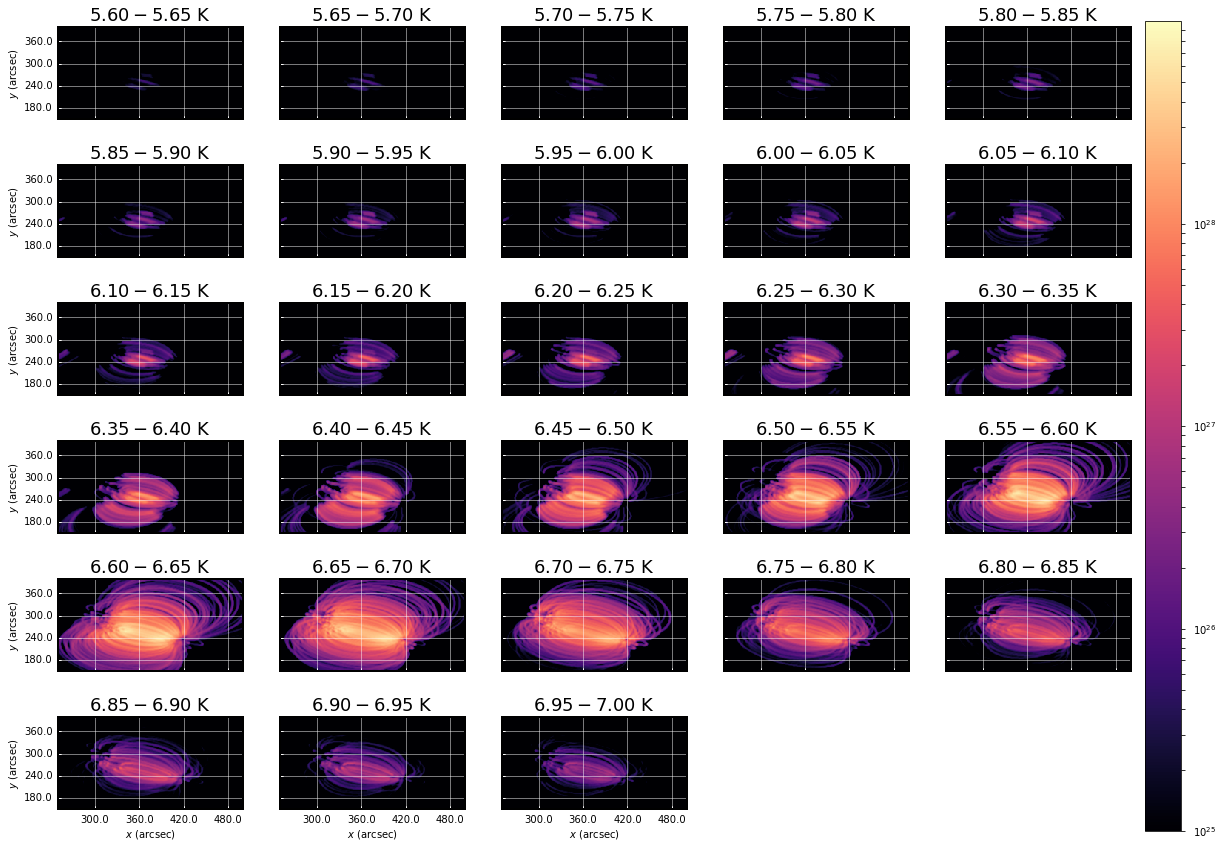

In [56]:
fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(groundtruth_cubes[250].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = groundtruth_cubes[250][i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
#pow_ticks = [i+21 for i in range(10)]
cbar = fig.colorbar(im,
                    #ticks=10.**np.array(pow_ticks),
                    cax=cax,
                    #format=LogFormatter(10,labelOnlyBase=False)
                   )

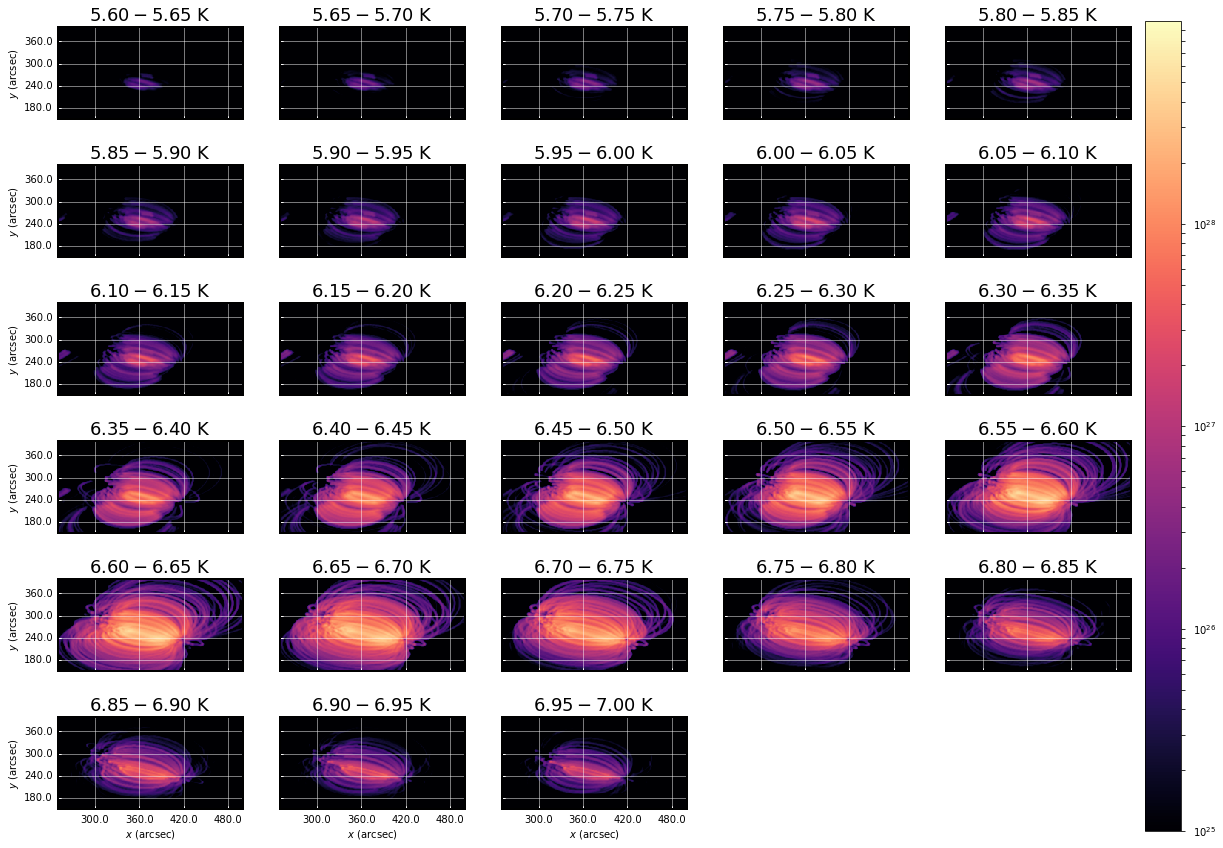

In [58]:
fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(groundtruth_cubes[750].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = groundtruth_cubes[750][i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
#pow_ticks = [i+21 for i in range(10)]
cbar = fig.colorbar(im,
                    #ticks=10.**np.array(pow_ticks),
                    cax=cax,
                    #format=LogFormatter(10,labelOnlyBase=False)
                   )

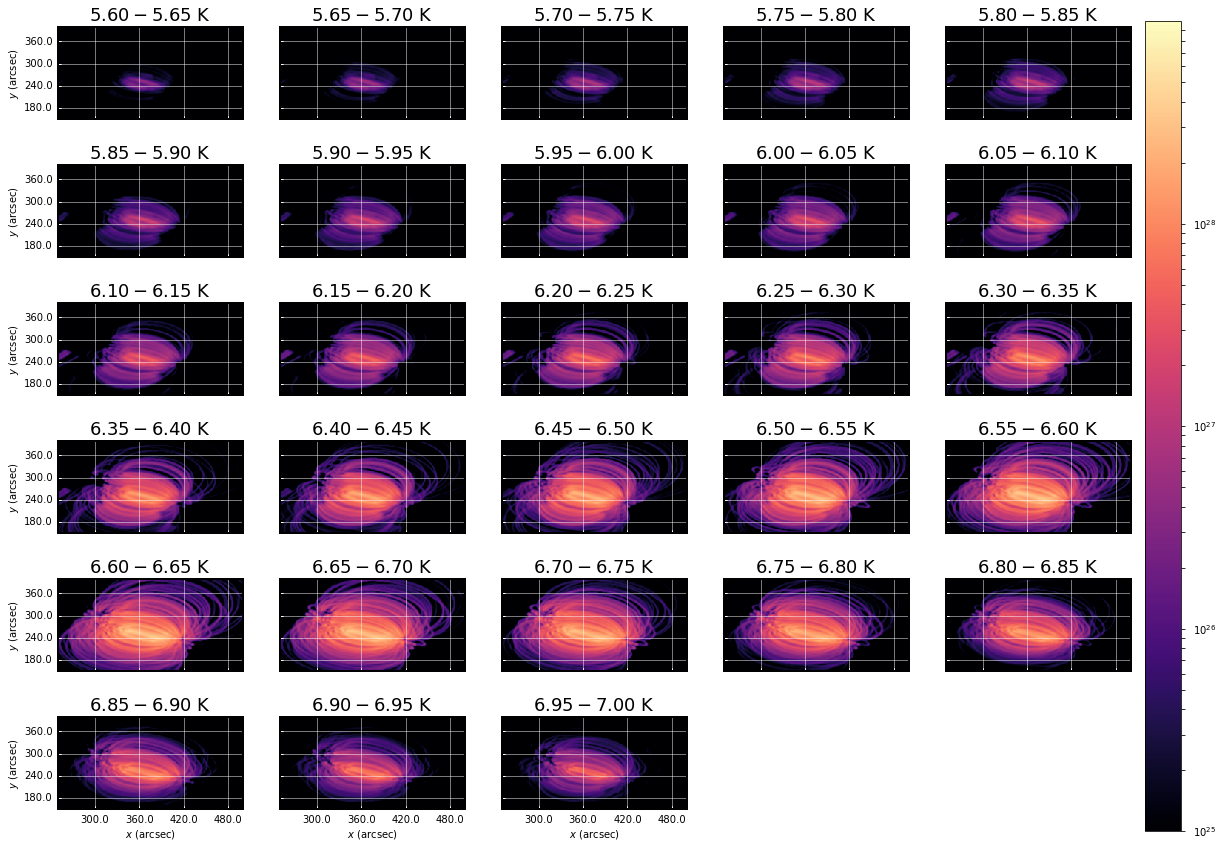

In [59]:
fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(groundtruth_cubes[2500].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = groundtruth_cubes[2500][i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
#pow_ticks = [i+21 for i in range(10)]
cbar = fig.colorbar(im,
                    #ticks=10.**np.array(pow_ticks),
                    cax=cax,
                    #format=LogFormatter(10,labelOnlyBase=False)
                   )
#cbar.set_ticklabels([r'$10^{{{}}}$'.format(t) for t in pow_ticks],update_ticks=True)
#fig.suptitle(r'Emission Measure, $\mathrm{EM}(T)$ ($\mathrm{cm}^{-5}$)')

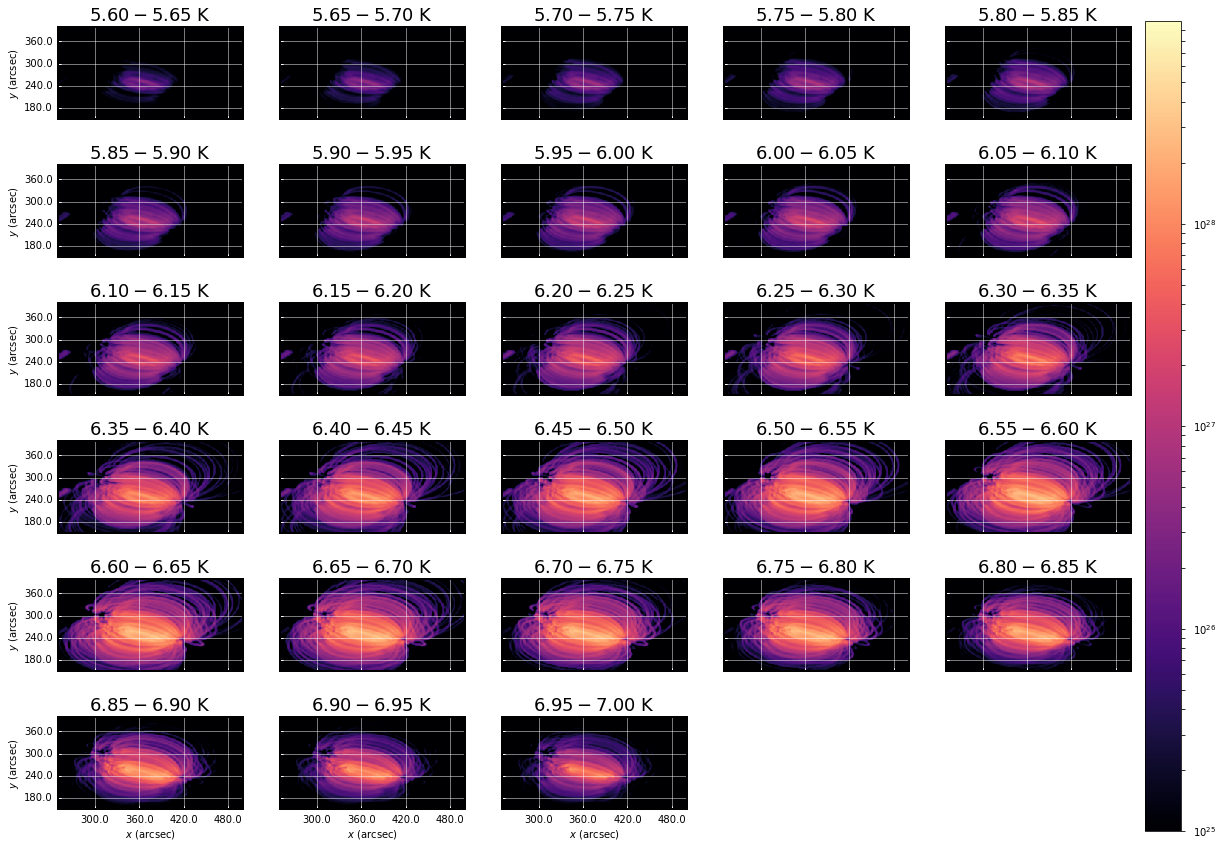

In [61]:
fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(groundtruth_cubes[5000].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = groundtruth_cubes[5000][i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
#pow_ticks = [i+21 for i in range(10)]
cbar = fig.colorbar(im,
                    #ticks=10.**np.array(pow_ticks),
                    cax=cax,
                    #format=LogFormatter(10,labelOnlyBase=False)
                   )

## Inverted Emission Measure Distribution
We'll compute the DEM in another way by using the time-averaged intensities for each line that we've synthesized. First, we'll time-average the EIS data cubes and then cut on each of the lines to get a set of time-averaged intensity maps for each heating frequency. These, along with the contribution functions, are then input into the demreg code to calculate a regularized EMCube.

### Average Intensities for Each Resolved Line

Average the EMCubes and then slice at the end. We'll also need to divide by the number of timesteps to compute the time average and then convert to the appropriate physical units using the photon energy and the wavelength response function.

In [16]:
time_averaged_em_cubes = {freq:{chan['name']:None for chan in eis.channels} for freq in frequencies}

In [17]:
for freq in frequencies:
    print('t_N = {}'.format(freq))
    for channel in eis.channels:
        print('channel = {}'.format(channel['name']))
        for i,t in enumerate(eis.observing_time):
            path2file = os.path.join(base.format(freq),
                                     'Hinode_EIS',channel['name'],
                                     'map_t{:06d}.h5'.format(i+750))
            if time_averaged_em_cubes[freq][channel['name']] is None:
                time_averaged_em_cubes[freq][channel['name']] = EISCube(path2file)
            else:
                time_averaged_em_cubes[freq][channel['name']] += EISCube(path2file)

t_N = 250
channel = 170-210


channel = 250-290
t_N = 750
channel = 170-210
channel = 250-290
t_N = 2500
channel = 170-210


channel = 250-290
t_N = 5000
channel = 170-210
channel = 250-290


Time average and convert to appropriate units.

In [18]:
for freq in frequencies[0:1]:
    for channel in eis.channels:
        tmp = time_averaged_em_cubes[freq][channel['name']]
        conversion = splev(tmp.wavelength.value,
                           splrep(channel['response']['x'].value,channel['response']['y'].value))
        conversion = conversion*channel['response']['y'].unit
        conversion /= const.h.cgs*const.c.cgs/tmp.wavelength.to(u.cm)/u.photon
        time_averaged_em_cubes[freq][channel['name']] = tmp*(1./conversion)*(1./eis.observing_time.shape[0])

Load emission model and collect resolved wavelengths and **sort** the resolved wavelengths in increasing order.

In [19]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

In [20]:
resolved_wavelengths = np.sort(u.Quantity([rw for ion in emission_model.ions for rw in ion.resolved_wavelengths]))

Check the specific intensities for each channel for each frequency for a particular spot in the AR.

In [312]:
df['Observed intensity'].iloc[0]

749.75999999999999

In [314]:
df['Wavelength']

172    180.401
171    184.536
173    188.216
169    188.497
176    192.394
189    192.858
186    193.874
185    194.396
177    195.119
170    197.862
187    200.972
178    202.044
179    203.826
188    208.604
183    256.686
175    258.375
184    262.984
174    264.233
180    264.787
181    270.519
168    275.368
182    284.160
Name: Wavelength, dtype: float64

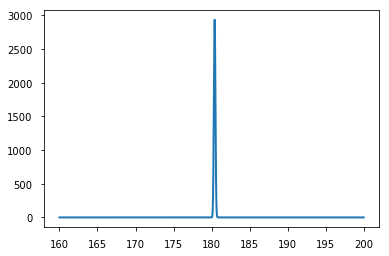

In [317]:
test_wvl = np.linspace(160,200,1000)
test_spread = df['Observed intensity'].iloc[0]*ch_filters.gaussian(test_wvl,df['Wavelength'].iloc[0],0.1)
plt.plot(test_wvl,test_spread)

In [286]:
tmp_spec_intensity = {freq:{} for freq in frequencies}
for i,freq in enumerate(frequencies):
    # channel 1
    tmp = time_averaged_em_cubes[freq][eis.channels[0]['name']]
    tmp_spec_intensity[freq][eis.channels[0]['name']] = tmp.submap(u.Quantity((left_x,right_x)),
                                                        u.Quantity((bottom_y,top_y))).data.mean(axis=(0,1))
    # channel 2
    tmp = time_averaged_em_cubes[freq][eis.channels[1]['name']]
    tmp_spec_intensity[freq][eis.channels[1]['name']] = tmp.submap(u.Quantity((left_x,right_x)),
                                                        u.Quantity((bottom_y,top_y))).data.mean(axis=(0,1))


In [318]:
eis.channels[0]

{'instrument_width': <Quantity 0.06 Angstrom>,
 'model_wavelengths': <Quantity [ 180.401 , 184.537 , 188.216 , 188.493 , 192.394 , 192.8532,
             193.8661, 194.401 , 195.119 , 197.854 , 200.9719, 202.044 ,
             203.826 , 208.585 ] Angstrom>,
 'name': '170-210',
 'response': {'x': <Quantity [ 170.   , 170.022, 170.045,...,  209.939, 209.962, 209.984] Angstrom>,
  'y': <Quantity [  2.46067000e-16,  3.04611000e-16,  8.56596000e-16,...,
               7.31381000e-13,  7.28324000e-13,  7.25280000e-13] cm2 ct sr / (ph pix)>},
 'spectral_resolution': <Quantity 0.0017 Angstrom>,
 'wavelength': <Quantity 189.99200000000002 Angstrom>,
 'wavelength_range': <Quantity [ 170.   , 209.984] Angstrom>}

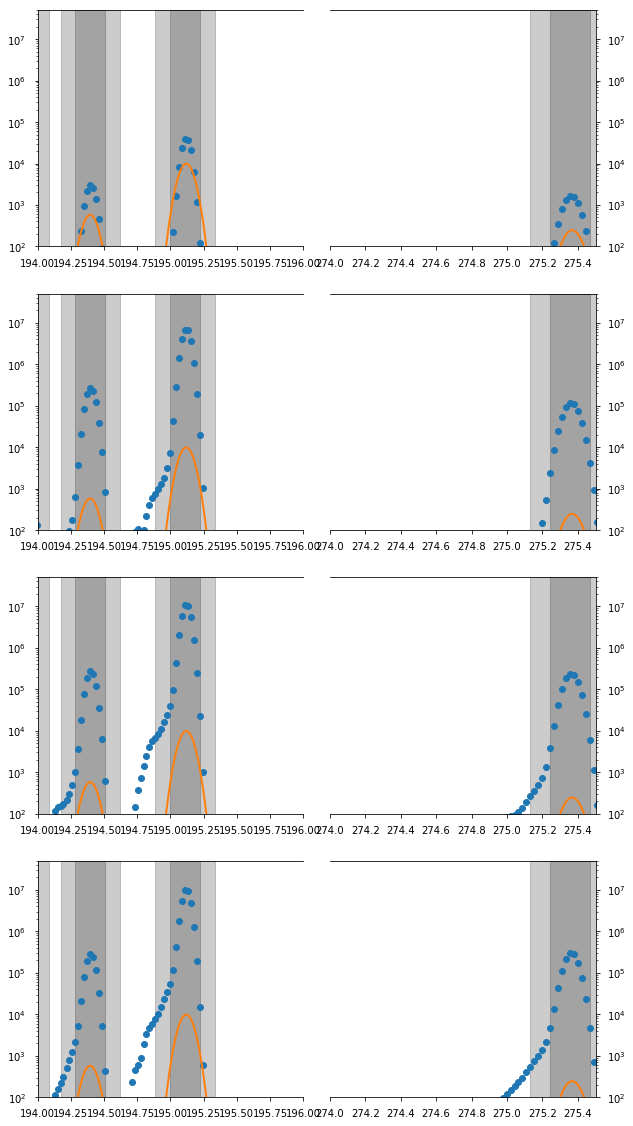

In [668]:
fig,axes = plt.subplots(4,2,figsize=(10,20),sharey=True)
plt.subplots_adjust(wspace=0.1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim([1e2,5e7])
for i,freq in enumerate(frequencies):
    # channel 1
    axes[i,0].plot(time_averaged_em_cubes[freq][eis.channels[0]['name']].wavelength,
                   tmp_spec_intensity[freq][eis.channels[0]['name']],'o')
    # channel 2
    axes[i,1].plot(time_averaged_em_cubes[freq][eis.channels[1]['name']].wavelength,
                   tmp_spec_intensity[freq][eis.channels[1]['name']],'o')
    # overplot observed intensity
    test_wvl = np.linspace(eis.channels[0]['response']['x'][0].value,
                           eis.channels[1]['response']['x'][-1].value,100000)
    test_spread = np.zeros(test_wvl.shape)
    for w0,obs_intensity in zip(df['Wavelength'],df['Observed intensity']):
        test_spread += obs_intensity*ch_filters.gaussian(test_wvl,w0,0.05)
    axes[i,0].plot(test_wvl,test_spread)
    axes[i,1].plot(test_wvl,test_spread)
    # shade sums
    for j,chan in enumerate(eis.channels):
        for rw in resolved_wavelengths:
            i_center = np.where(np.isclose(time_averaged_em_cubes[freq][chan['name']].wavelength.value,
                                           rw.value,atol=1.1e-2,rtol=0.))[0]
            if len(i_center) == 0:
                continue
            axes[i,j].axvspan(time_averaged_em_cubes[freq][chan['name']].wavelength[i_center-5].value,
                              time_averaged_em_cubes[freq][chan['name']].wavelength[i_center+5].value,
                              color='k',alpha=0.2)
            axes[i,j].axvspan(time_averaged_em_cubes[freq][chan['name']].wavelength[i_center-10].value,
                              time_averaged_em_cubes[freq][chan['name']].wavelength[i_center+10].value,
                              color='k',alpha=0.2)
    # despine
    sns.despine(ax=axes[i,0],top=False)
    sns.despine(ax=axes[i,1],top=False,right=False,left=True)
    #axes[i,0].set_xlim([eis.channels[0]['response']['x'][0].value,
    #                    eis.channels[0]['response']['x'][-1].value])
    axes[i,0].set_xlim([194,196])
    axes[i,1].set_xlim([274,275.5])
    #axes[i,1].set_xlim([eis.channels[1]['response']['x'][0].value,
    #                    eis.channels[1]['response']['x'][-1].value])


Slice the cube in wavelength space and create the intensity map for each distinct spectral line for each frequency.

In [334]:
averaged_intensities = {freq:{rw:None for rw in resolved_wavelengths} for freq in frequencies}

In [335]:
for freq in frequencies:
    for channel in eis.channels:
        tmp = time_averaged_em_cubes[freq][channel['name']]
        for rw in resolved_wavelengths:
            i_center = np.where(np.isclose(tmp.wavelength.value,rw.value,atol=1.1e-2,rtol=0.))[0]
            if len(i_center) == 0:
                continue
            averaged_intensities[freq][rw] = tmp[i_center-5:i_center+5].integrated_intensity
            averaged_intensities[freq][rw].data = gaussian_filter(averaged_intensities[freq][rw].data,
                                                                  (3./eis.resolution.y.value,
                                                                   3./eis.resolution.x.value))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:1023: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out = super(Quantity, self).__getitem__(key)


Take a look at the time-averaged intensities for one of the heating frequencies.

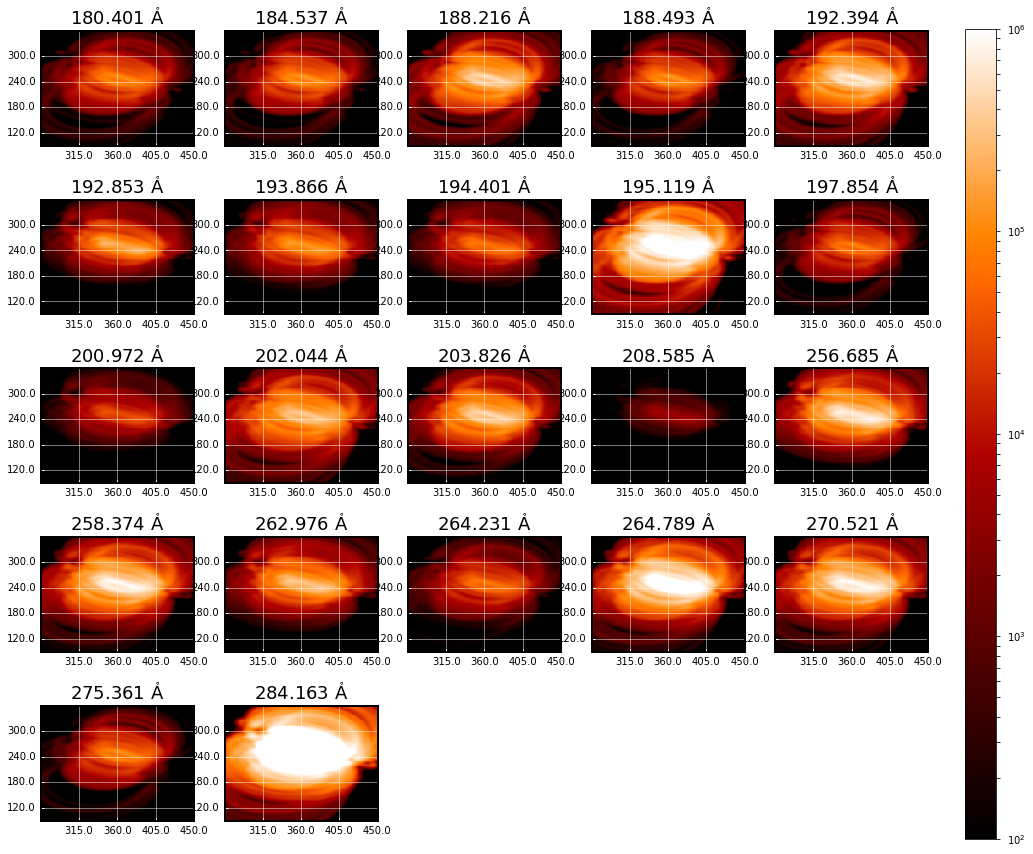

In [336]:
fig = plt.figure(figsize=(17,15))
plt.subplots_adjust(right=0.85)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
for i,rw in enumerate(resolved_wavelengths):
    tmp = (averaged_intensities[5000][rw]
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec))
          )
    ax = fig.add_subplot(5,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,annotate=False,title=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e2,vmax=1e6)
                 )
    ax.set_title(r'{:.3f} {}'.format(rw.value,rw.unit.to_string(format='latex')))
cbar = fig.colorbar(im,cax=cax)

### Calculate Contribution Functions
Calculate the contribution functions for each of the resolved lines that we've synthesized with EIS.

In [614]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    electron_temperature = np.logspace(5,8,100)*u.K
    density = pressure_const/electron_temperature
    
fake_loop = FakeLoop()
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

In [615]:
contribution_functions = {}
line_names = {}
for ion in emission_model.ions:
    for rw in ion.resolved_wavelengths:
        i_rw = np.where(ion.wavelength==rw)[0][0]
        emiss = map_coordinates(ion.emissivity[:,:,i_rw].value,
                                np.vstack([i_temperature,i_density]),order=3)*ion.emissivity.unit
        ioneq = splev(fake_loop.electron_temperature.value,
                      splrep(emission_model.temperature_mesh[:,0].value,
                             ion.fractional_ionization[:,0].value,k=1),ext=1)
        line_names[rw] = '{} {}'.format(ion.chianti_ion.meta['name'],rw.value)
        contribution_functions[rw] = (1./(np.pi*4.*u.steradian)*0.83
                                           *ioneq*ion.chianti_ion.abundance*emiss/fake_loop.density
                                           *(const.h.cgs*const.c.cgs)/rw.to(u.cm)/u.photon)

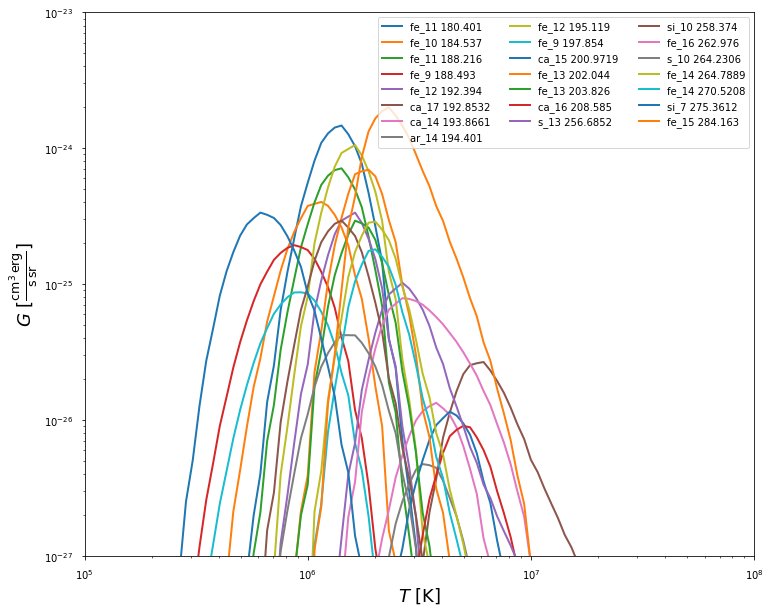

In [616]:
gofnt_colors = {rw : sns.color_palette(n_colors=resolved_wavelengths.shape[0])[i] 
                for i,rw in enumerate(resolved_wavelengths)}
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
for rw in resolved_wavelengths:
    ax.plot(fake_loop.electron_temperature,contribution_functions[rw],
            color=gofnt_colors[rw],alpha=1.,
            label='{}'.format(line_names[rw]))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-27,1e-23])
ax.set_xlim([fake_loop.electron_temperature[0].value,
             fake_loop.electron_temperature[-1].value])
ax.set_xlabel(r'$T$ [{:latex}]'.format(fake_loop.electron_temperature.unit))
ax.set_ylabel(r'$G$ [{:latex}]'.format(contribution_functions[rw][1].unit))
ax.legend(loc=1,ncol=3)

### Transform Data
We need to transform the data so that it can be input into the HK12 DEM inversion code. We need the following pieces of data:
* intensity-$N_y\times N_x\times N_{\lambda}$, cube holding all of the intensity values, 3rd dimension should be ordered by increasing wavelength
* $K$ matrix-$N_T\times N_{\lambda}$, 2D array holding contribution functions as a function of temperature, 2nd dimension should be ordered by increasing wavelength
* $T$ array-$N_T$, 1D array with temperatures over which the contribution function is calculated
* $T^*$ array-$N_{T^*}$, 1D array of temperature bins to sort the $\mathrm{EM}(T)$ into

It seems that the 3D intensity array is too big to just print to file so we'll try printing each $\lambda$ as a separate FITS file and then loading it in with `readsdo`

In [35]:
k_matrix = []
intensity_matrix = []
line_names = []
for rw in resolved_wavelengths:
    line_name = '{}_{}'.format(rw.value,rw.unit)
    line_names.append(line_name)
    k_matrix.append(contribution_functions[rw].value.tolist())
    for freq in frequencies:
        averaged_intensities[freq][rw].save('../tmp_data/eis_map_{}_{}.fits'.format(freq,line_name))
    

### Apply DEM Inversion Method

In [36]:
demreg_runner = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl/'],
                                  ssw_path_list=['vobs','ontology'])
static_input_vars = {
                     'log_temperature':np.log10(fake_loop.electron_temperature.value).tolist(),
                     'temperature_bins':temperature_bin_edges.value.tolist(),
                     'k_matrix':k_matrix,
                     'names':line_names,
                     'error_ratio':0.2,
                     'gloci':1,'reg_tweak':1,'timed':1
                    }
save_vars = ['dem','edem','elogt','chisq','dn_reg']

In [37]:
demreg_script = """
; load intensity from each channel/line
names = {{ names }}
eis_file_list = find_file('{{ fits_file_glob }}')
read_sdo,eis_file_list,ind,intensity
; load the contribution functions or response functions (called K in Hannah and Kontar 2012)
k_matrix = {{ k_matrix }}
; load temperature array over which K is computed
log_temperature = {{ log_temperature }}

; temperature bins
temperature_bins = {{ temperature_bins }}

; crude estimate of intensity errors
intensity_errors = intensity*{{ error_ratio }}

; inversion method parameters
reg_tweak={{ reg_tweak }}
timed={{ timed }}
gloci={{ gloci }}

; run the inversion method
dn2dem_pos_nb,intensity,intensity_errors,$
              k_matrix,log_temperature,temperature_bins,$
              dem,edem,elogt,chisq,dn_reg,$
              timed=timed,gloci=gloci,reg_tweak=reg_tweak
"""

In [38]:
dem_output = {}

In [39]:
for freq in frequencies:
    input_vars = static_input_vars.copy()
    input_vars['fits_file_glob'] = '/home/wtb2/Documents/projects/systematic_ar_study/tmp_data/eis_map_{}_*.fits'.format(freq)
    dem_output[freq] = demreg_runner.run([(demreg_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=True)

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

Now convert the output from the DEMREG code to an `EMCube` object so that we can more easily work with it.

In [40]:
demreg_cubes = {}

In [41]:
for freq in frequencies:
    demreg_cubes[freq] = EMCube(np.swapaxes(dem_output[freq]['dem'].T,0,1)*np.diff(temperature_bin_edges.value)*(u.cm**(-5)),
                                (averaged_intensities[freq][resolved_wavelengths[0]].meta),
                                temperature_bin_edges,
                                plot_settings={'cmap':plt.get_cmap('magma'),
                                               'norm':matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29)})

Now, take a look at each of the regularized EM distributions.

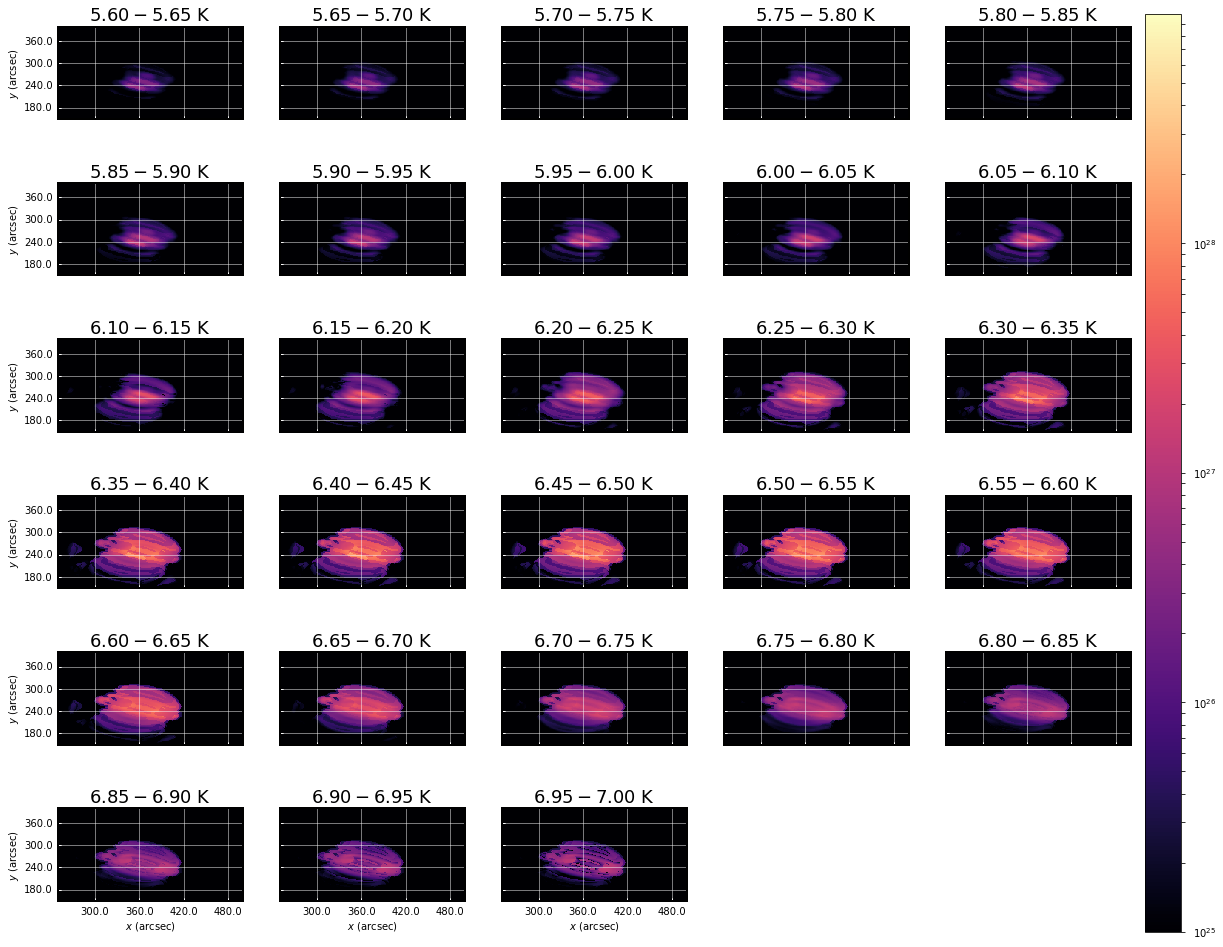

In [70]:
fig = plt.figure(figsize=(20,17))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(demreg_cubes[250].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = (demreg_cubes[250][i]
           .submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
          )
    #tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False)
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
cbar = fig.colorbar(im,cax=cax)

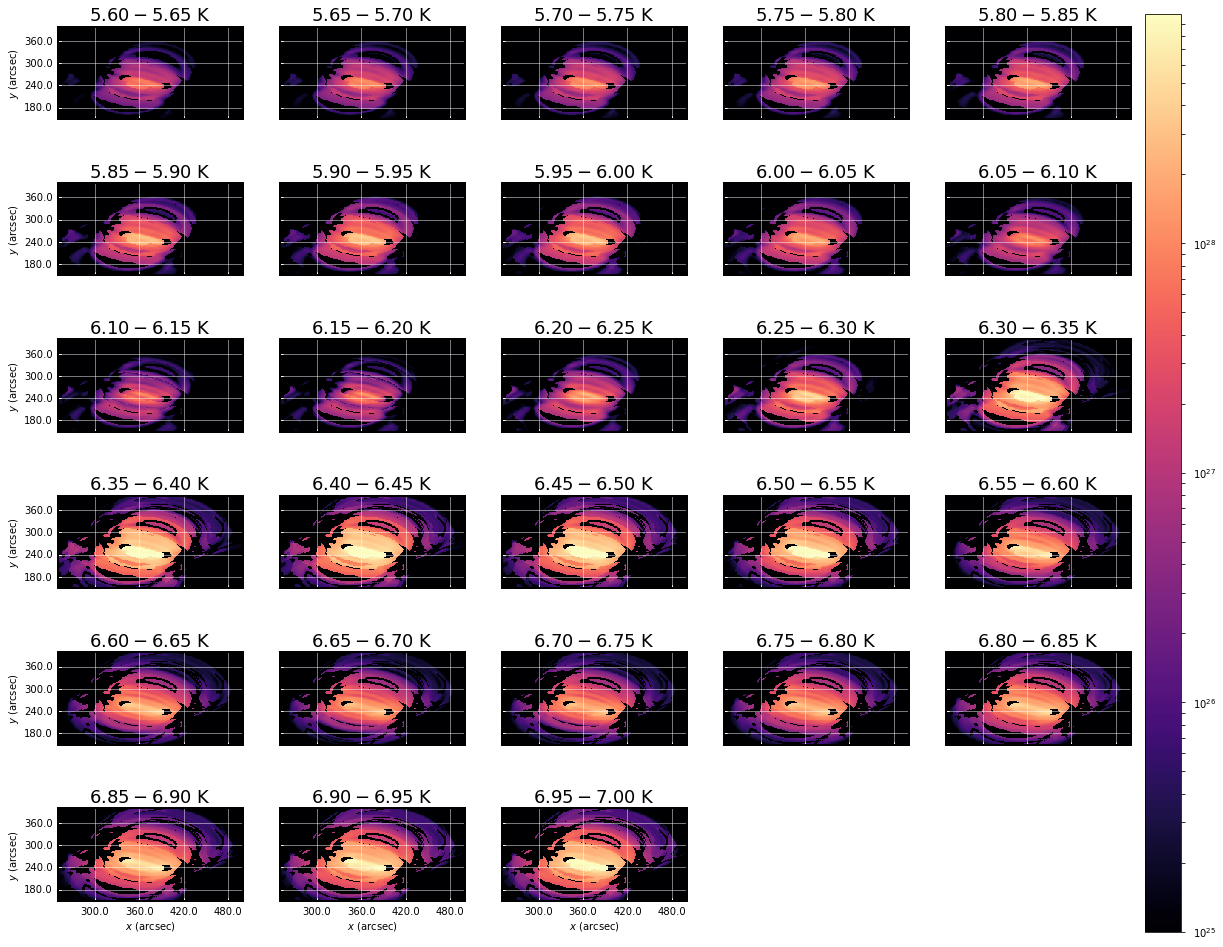

In [71]:
fig = plt.figure(figsize=(20,17))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(demreg_cubes[750].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = (demreg_cubes[750][i]
           .submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
          )
    #tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False)
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
cbar = fig.colorbar(im,cax=cax)

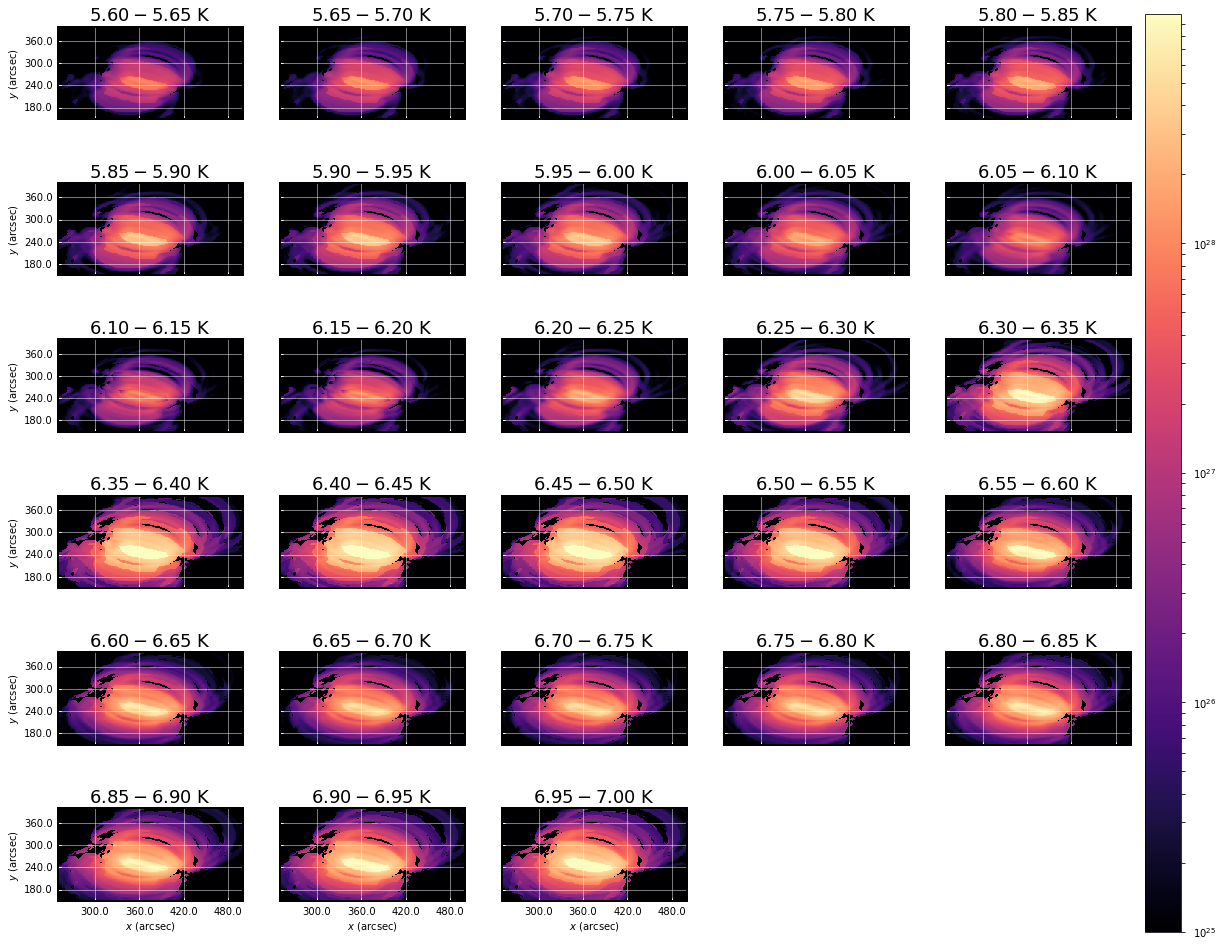

In [72]:
fig = plt.figure(figsize=(20,17))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(demreg_cubes[2500].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = (demreg_cubes[2500][i]
           .submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
          )
    #tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False)
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
cbar = fig.colorbar(im,cax=cax)

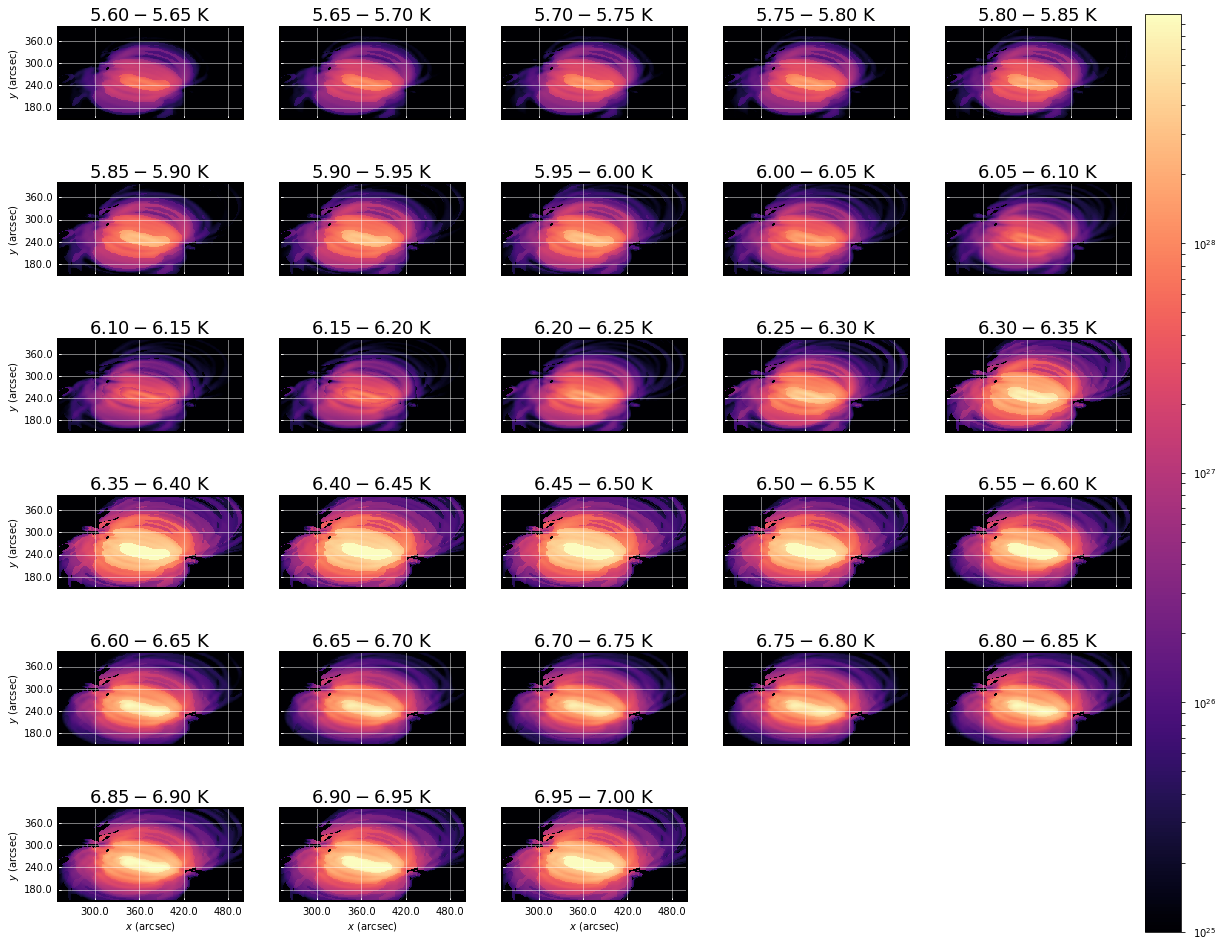

In [73]:
fig = plt.figure(figsize=(20,17))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(demreg_cubes[5000].temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = (demreg_cubes[5000][i]
           .submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
          )
    #tmp.data = gaussian_filter(tmp.data,aia.channels[0]['gaussian_width'].value)
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False)
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
cbar = fig.colorbar(im,cax=cax)

## Compare Slope Distributions
Compare the distribution of $a$ values across heating frequencies and between the "ground truth" results and the regularized inversion results. We'll measure the EM slope per pixel across the whole AR and then compare the distributions for various heating frequencies and between the "true" results and regularized inversion results.

In [177]:
warren_a_ar9_nominal = 4.3
warren_a_ar9_uncertainty = 0.47
warren_a_ar9_nominal_hk12 = 3.0305338512
warren_a_ar9_plus_hk12 = 3.29036944328
warren_a_ar9_minus_hk12 = 2.88272291218

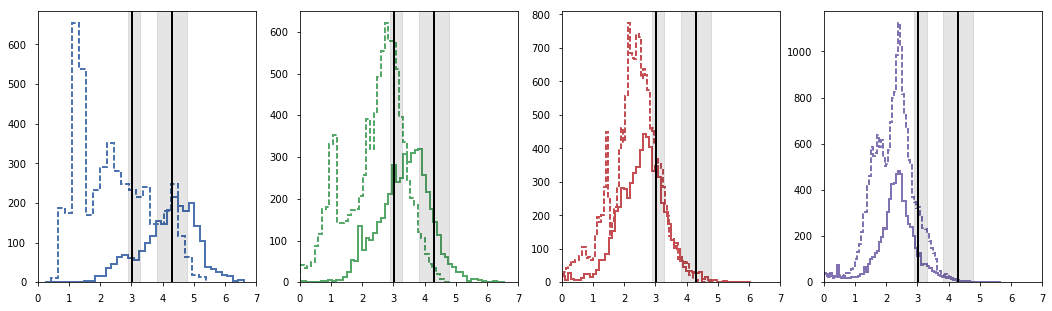

In [178]:
fig,axes = plt.subplots(1,4,figsize=(18,5),sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)
colors = sns.color_palette('deep')
for ax,(i,freq) in zip(axes.flatten(),enumerate(frequencies)):
    #### Ground Truth ####
    tmp = groundtruth_cubes[freq].make_slope_map(em_threshold=1e25*u.cm**(-5),
                                                 temperature_bounds=u.Quantity((1e6,4e6),u.K)).data.flatten()
    tmp = tmp[tmp>0]
    _,bins = np.histogram(tmp,bins='fd')
    ax.hist(tmp,bins=bins,
            histtype='step',
            #log=True,
            label='$t_N={}$ s, truth'.format(freq),
            #normed=True,
            lw=2,
            #alpha=0.4,
            #cumulative=True,
            color=colors[i]
           )
    #### Regularized Inversion ####
    tmp = demreg_cubes[freq].make_slope_map(em_threshold=1e25*u.cm**(-5),
                                            temperature_bounds=u.Quantity((1e6,4e6),u.K)).data.flatten()
    tmp = tmp[tmp>0]
    _,bins = np.histogram(tmp,bins='fd')
    ax.hist(tmp,bins=bins,
            histtype='step',
            #log=True,
            label='$t_N={}$ s, demreg'.format(freq),
            #normed=True,
            lw=2,
            ls='--',
            #alpha=0.4,
            #cumulative=True,
            color=colors[i]
           )
    #### Warren et al result ####
    # from paper
    ax.axvspan(warren_a_ar9_nominal - warren_a_ar9_uncertainty,
               warren_a_ar9_nominal + warren_a_ar9_uncertainty,
              color='k',alpha=0.1)
    ax.axvline(x=warren_a_ar9_nominal,color='k')
    # from HK12 applied to reported intensities
    ax.axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
    ax.axvline(x=warren_a_ar9_nominal_hk12,color='k')
    ax.set_xlim([0,7])
    #ax.legend(loc=2)
    #ax.set_ylim([0,.07])

We can also plot maps of the emission measure slope.

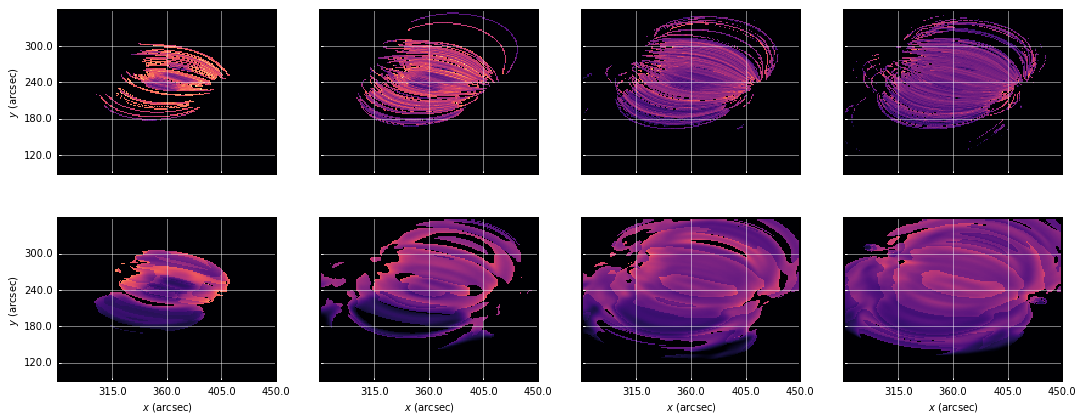

In [106]:
fig = plt.figure(figsize=(18,7))
#plt.subplots_adjust(right=0.85)
#cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
for i,freq in enumerate(frequencies):
    #### Ground Truth ####
    tmp = (groundtruth_cubes[freq].make_slope_map(temperature_bounds=u.Quantity((1e6,4e6),u.K))
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec))
          )
    ax = fig.add_subplot(2,4,i+1,projection=tmp)
    custom_cmap = plt.get_cmap('magma')
    im = (tmp.plot(vmin=0,vmax=7,cmap=custom_cmap,axes=ax,title=False,annotate=False,norm=None))
    if i==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    #### Regularized Inversion ####
    tmp = (demreg_cubes[freq].make_slope_map(temperature_bounds=u.Quantity((1e6,4e6),u.K))
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec))
          )
    ax = fig.add_subplot(2,4,i+5,projection=tmp)
    custom_cmap = plt.get_cmap('magma')
    im = (tmp.plot(vmin=0,vmax=7,cmap=custom_cmap,axes=ax,title=False,annotate=False,norm=None))
    ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
#cbar = fig.colorbar(im,cax=cax)

## 1D EM Distributions for Area in Warren et al., 2012
Also should compare this with the 1D distributions from the inverted case and from the actual data that we can scrape from the machine readable tables provided by Warren et al.

Read the intensities from the machine-readable table in Warren et al. (2012) and then run these through the demreg code as well so for each heating frequency, we can overplot three EM distributions.

In [671]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt')
                     .readlines())
col_names = [str(t.strip()).split('  ')[-1] for t in tmp[8:15]]
col_names = [c[:-1] for c in col_names[0:2]] + ['Element','Ion','Wavelength'] + [c[:-1] for c in col_names[3:]]
table_io = io.StringIO(','.join(col_names) + '\n' 
                       + '\n'.join([','.join(filter(None,t.strip().decode('utf8').split(' '))) for t in tmp[19:]]))
df = pandas.read_csv(table_io)
df = df[df['Active region']==9]
df = df[df['Instrument (1)']=='EIS']
df = df.sort('Wavelength')

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [672]:
df

Active region Instrument (1) Element   Ion  Wavelength  \
172              9            EIS      Fe    XI     180.401   
171              9            EIS      Fe     X     184.536   
173              9            EIS      Fe    XI     188.216   
169              9            EIS      Fe    IX     188.497   
176              9            EIS      Fe   XII     192.394   
189              9            EIS      Ca  XVII     192.858   
186              9            EIS      Ca   XIV     193.874   
185              9            EIS      Ar   XIV     194.396   
177              9            EIS      Fe   XII     195.119   
170              9            EIS      Fe    IX     197.862   
187              9            EIS      Ca    XV     200.972   
178              9            EIS      Fe  XIII     202.044   
179              9            EIS      Fe  XIII     203.826   
188              9            EIS      Ca   XVI     208.604   
183              9            EIS       S  XIII     256.686   
175              9            EIS      Si     X     258.375   
184              9            EIS      Fe   XVI     262.984   
174              9            EIS       S     X     264.233   
180              9            EIS      Fe   XIV     264.787   
181              9            EIS      Fe   XIV     270.519   
168              9            EIS      Si   VII     275.368   
182              9            EIS      Fe    XV     284.160   

     Observed intensity  Error in OInt  \
172              749.76         165.15   
171              210.65          46.40   
173              467.97         102.97   
169               46.43          10.26   
176              386.91          85.13   
189              120.88          26.67   
186              308.59          67.90   
185               72.31          15.92   
177             1236.18         271.97   
170               29.40           6.49   
187              251.50          55.36   
178             1243.57         273.61   
179             2117.38         465.89   
188              129.22          28.69   
183              606.92         133.56   
175              218.87          48.19   
184              961.55         211.56   
174               53.29          11.77   
180              817.39         179.85   
181              428.69          94.33   
168               30.76           6.81   
182             8064.20        1774.18   

     Differential emission measure intensity   Ratio of OInt to DInt  
172                                   891.80                    0.84  
171                                   168.10                    1.25  
173                                   443.68                    1.05  
169                                    46.55                    1.00  
176                                   340.03                    1.14  
189                                   113.19                    1.07  
186                                   254.06                    1.21  
185                                    75.10                    0.96  
177                                  1060.09                    1.17  
170                                    29.01                    1.01  
187                                   196.20                    1.28  
178                                   612.40                    2.03  
179                                  1026.28                    2.06  
188                                   108.38                    1.19  
183                                   689.79                    0.88  
175                                   272.98                    0.80  
184                                   994.69                    0.97  
174                                    57.22                    0.93  
180                                   837.90                    0.98  
181                                   430.03                    1.00  
168                                    32.29                    0.95  
182                       

In [482]:
class DEM1DResults(object):
    
    def __init__(self,dem_results):
        self.temperature_bins = np.float64(dem_results['temperature_bins'])
        self.temperature_bin_centers = (self.temperature_bins[:-1] + self.temperature_bins[1:])/2.
        self.temperature_error_plus = self.temperature_bin_centers*(10.**(dem_results['elogt']) - 1.)
        self.temperature_error_minus = self.temperature_bin_centers*(1. - 10.**(-dem_results['elogt']))
        self.dem = dem_results['dem']
        self.em = dem_results['dem']*np.diff(self.temperature_bins)
        self.dem_errors = dem_results['edem']
        self.em_errors = np.diff(self.temperature_bins)*dem_results['edem']
        self.chi_squared = dem_results['chisq']
        self.regularized_data = dem_results['dn_reg']

In [677]:
temperature_bins = 10.**(np.arange(5.6,7.0,0.05))
gofnt_trim = np.where(np.logical_and(fake_loop.electron_temperature.value>=temperature_bins[0],
                                     fake_loop.electron_temperature.value<=temperature_bins[-1]))
static_input_vars = {
                     'log_temperature':np.log10(fake_loop.electron_temperature.value[gofnt_trim]).tolist(),
                     'temperature_bins':temperature_bins.tolist(),
                     'k_matrix':[(contribution_functions[rw][gofnt_trim]).value.tolist() for rw in resolved_wavelengths],
                     'names':['{} {}'.format(rw.value,rw.unit) for rw in resolved_wavelengths],
                     'error_ratio':0.3,
                     'gloci':1,'reg_tweak':1,'timed':1,'rgt_fact':1.5
                    }
save_vars = ['dem','edem','elogt','chisq','dn_reg','temperature_bins']
demreg_script_1d = """
; load intensity from each channel/line
names = {{ names }}
intensity = {{ intensity }}
; load the contribution functions or response functions (called K in Hannah and Kontar 2012)
k_matrix = {{ k_matrix }}
; load temperature array over which K is computed
log_temperature = {{ log_temperature }}

; temperature bins
temperature_bins = {{ temperature_bins }}

; crude estimate of intensity errors
;intensity_errors = intensity*{{ error_ratio }}
intensity_errors = sqrt(intensity)

; inversion method parameters
reg_tweak={{ reg_tweak }}
timed={{ timed }}
gloci={{ gloci }}
rgt_fact={{ rgt_fact }}

; run the inversion method
dn2dem_pos_nb,intensity,intensity_errors,$
              k_matrix,log_temperature,temperature_bins,$
              dem,edem,elogt,chisq,dn_reg,$
              timed=timed,gloci=gloci,reg_tweak=reg_tweak,rgt_fact=rgt_fact
"""
demreg_runner1d = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl/'],
                                  ssw_path_list=['vobs','ontology'])

For the regularized (D)EM, the intensity over the specified area should be extracted from each of the intensity maps and then the demreg code run for each of these.

In [678]:
dem_output_1d = {}
for freq in frequencies:
    input_vars = static_input_vars.copy()
    input_vars['intensity'] = [averaged_intensities[freq][rw].submap(u.Quantity((left_x,right_x)),
                                                                     u.Quantity((bottom_y,top_y))).data.mean() 
                               for rw in resolved_wavelengths]
    dem_output_1d[freq] = DEM1DResults(demreg_runner1d.run([(demreg_script_1d,input_vars)],save_vars=save_vars,
                                        cleanup=True,verbose=True))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

In [679]:
input_vars = static_input_vars.copy()
input_vars['intensity'] = [float(df['Observed intensity'][df['Wavelength'].apply(np.isclose, b=rw.value, atol=2e-2)])
                           for rw in resolved_wavelengths]
dem_output_warren = DEM1DResults(demreg_runner1d.run([(demreg_script_1d,input_vars)],save_vars=save_vars,
                                                     cleanup=True,verbose=False))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


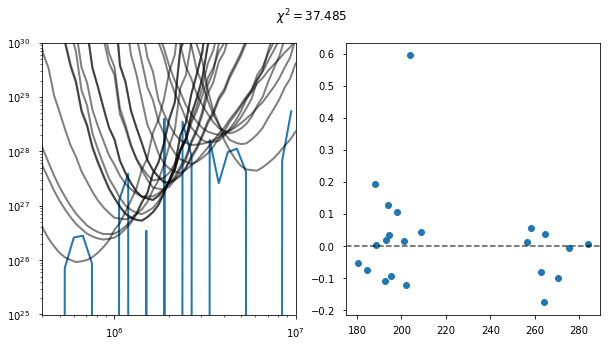

In [680]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(dem_output_warren.temperature_bin_centers,dem_output_warren.em)
for j,k in enumerate(resolved_wavelengths):
        axes[0].plot(fake_loop.electron_temperature,
                dem_output_warren.regularized_data[j]/contribution_functions[k],
                color='k',ls='-',alpha=0.5)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim([dem_output_warren.temperature_bins[0],
                  dem_output_warren.temperature_bins[-1]])
axes[0].set_ylim([1e25,1e30])
axes[1].plot(resolved_wavelengths,(np.array(input_vars['intensity'])
                                   -dem_output_warren.regularized_data)/np.array(input_vars['intensity']),'o')
axes[1].axhline(y=0,color='k',ls='--',alpha=0.5)
fig.suptitle(r'$\chi^2={:.3f}$'.format(dem_output_warren.chi_squared[0]))

For the ground-truth emission measure distributions, these can just be pulled straight out of the EMCube object.

In [665]:
def linear_fit(x,a,b):
        return a*x + b

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in log10


ValueError: array must not contain infs or NaNs

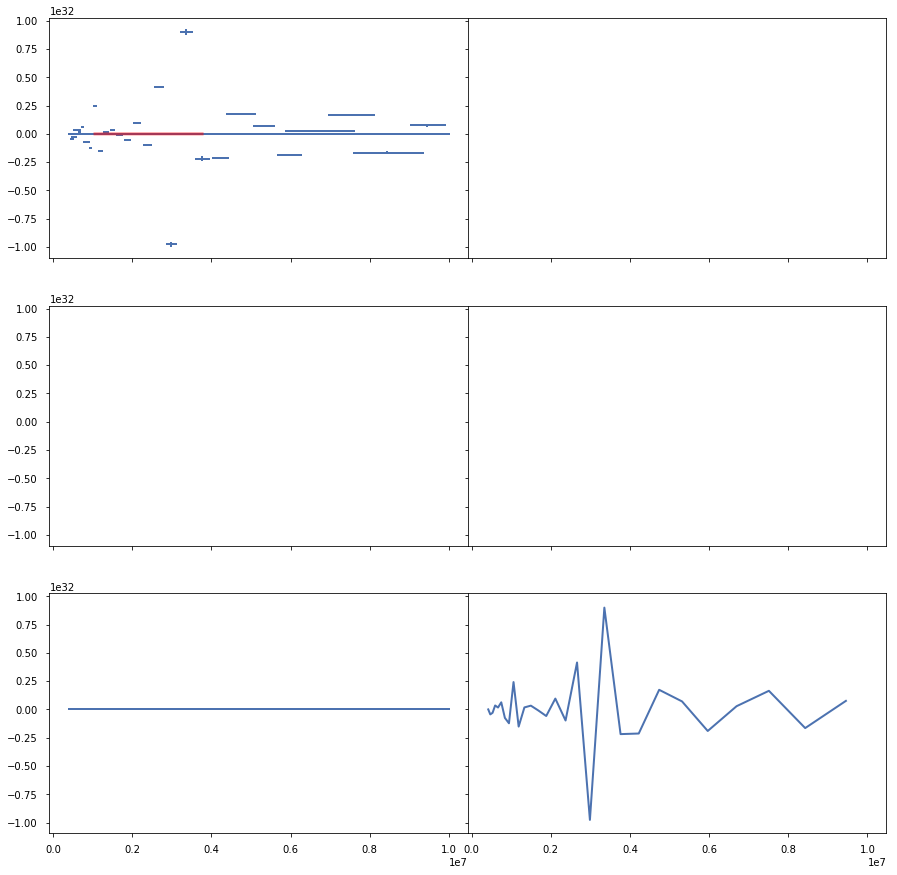

In [681]:
fig,axes = plt.subplots(3,2,figsize=(15,15),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0)
for ax,(i,freq) in zip(axes.flatten(),enumerate(frequencies)):
    #### Ground Truth ####
    # make 1d selection from boxed region
    _,em = groundtruth_cubes[freq].get_1d_distribution(u.Quantity((left_x,right_x)),
                                                       u.Quantity((bottom_y,top_y)))
    # compute slope
    t_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.
    i_fit = np.where(np.logical_and(t_bin_centers>=1e6*u.K,t_bin_centers<=4e6*u.K))
    t_fit = t_bin_centers[i_fit].value
    em_fit = em[i_fit].value
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    # plot
    ax.step(temperature_bin_edges[:-1],em,where='post',
            color=sns.color_palette('deep')[i],label=r'$t_N={}$ s, $a={:.2f}$'.format(freq,popt[0]))
    ax.step(temperature_bin_edges[1:],em,where='pre',
            color=sns.color_palette('deep')[i])
    axes[2,0].step(temperature_bin_edges[:-1],em,where='post',
            color=sns.color_palette('deep')[i],label=r'$t_N={}$ s, $a={:.2f}$'.format(freq,popt[0]))
    axes[2,0].step(temperature_bin_edges[1:],em,where='pre',
            color=sns.color_palette('deep')[i])
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='r',lw=3,ls='-',alpha=0.5)
    #### Regularized DEM ####
    # error bars
    ax.errorbar(dem_output_1d[freq].temperature_bin_centers,dem_output_1d[freq].em,
                yerr=dem_output_1d[freq].em_errors,
                xerr=[dem_output_1d[freq].temperature_error_minus,
                      dem_output_1d[freq].temperature_error_plus],
                ls='',marker='',color=sns.color_palette('deep')[i])
    axes[-1,1].plot(dem_output_1d[freq].temperature_bin_centers,dem_output_1d[freq].em,
                    color=sns.color_palette('deep')[i])
    # slope
    i_fit = np.where(np.logical_and(dem_output_1d[freq].temperature_bin_centers>=1e6,
                                    dem_output_1d[freq].temperature_bin_centers<=4e6))
    t_fit = dem_output_1d[freq].temperature_bin_centers[i_fit]
    em_fit = dem_output_1d[freq].em[i_fit]
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='r',lw=3,ls='--',alpha=0.5)
    # plot em loci 
    for j,k in enumerate(resolved_wavelengths):
        ax.plot(fake_loop.electron_temperature,
                dem_output_1d[freq].regularized_data[j]/contribution_functions[k],
                color='k',ls='-',alpha=0.5)
    #### Warren et al 2012 Results ####
    # error bars
    ax.errorbar(dem_output_warren.temperature_bin_centers,dem_output_warren.em,
                yerr=dem_output_warren.em_errors,
                xerr=[dem_output_warren.temperature_error_plus,dem_output_warren.temperature_error_minus],
                ls='',marker='',color='k')
    axes[-1,1].plot(dem_output_warren.temperature_bin_centers,dem_output_warren.em,
                    color='k')
    # slope
    i_fit = np.where(np.logical_and(dem_output_warren.temperature_bin_centers>=1e6,
                                    dem_output_warren.temperature_bin_centers<=4e6))
    t_fit = dem_output_warren.temperature_bin_centers[i_fit]
    em_fit = dem_output_warren.em[i_fit]
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='r',lw=3,ls='--',alpha=0.5)
    #### Labels and Limits ####
    #ax.legend(loc=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e25,1e30])
    ax.set_xlim([temperature_bins[0],temperature_bins[-1]])
    ax.set_title(r'$\chi^2 = {:.3f}$'.format(dem_output_1d[freq].chi_squared[0]))


(400000.0, 2000000.0)

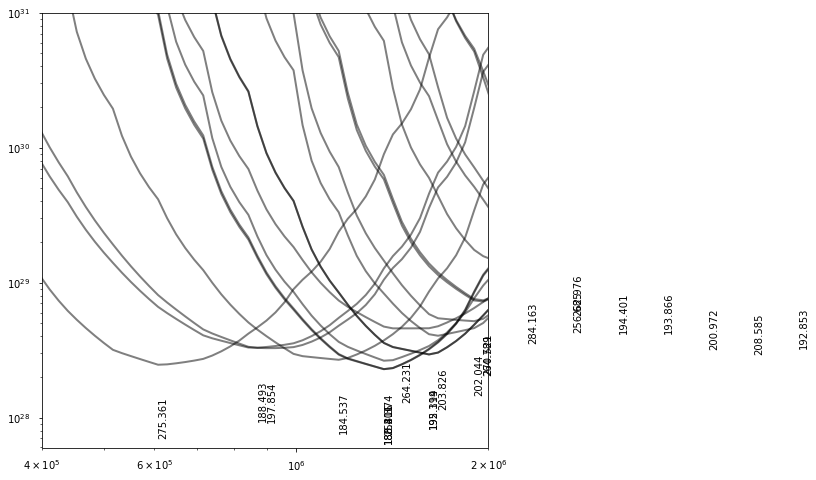

In [378]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for j,k in enumerate(resolved_wavelengths):
    em_loci = dem_output_1d[5000]['dn_reg'][j]/contribution_functions[k]
    plt.plot(fake_loop.electron_temperature,em_loci,
             color='k',ls='-',alpha=0.5)
    plt.text(fake_loop.electron_temperature[np.argmin(em_loci)].value,
             0.5*np.min(em_loci).value,
             '{:.3f}'.format(k.value),
             rotation='vertical')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([6e27,1e31])
ax.set_xlim([4e5,2e6])

## Intensity Errors

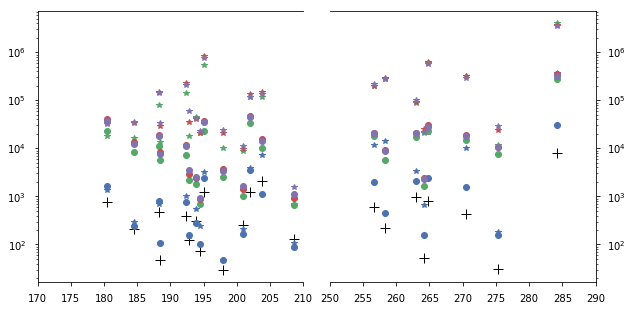

In [670]:
fig,axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
plt.subplots_adjust(wspace=0.1)
axes[0].plot(df['Wavelength'],df['Observed intensity'],'o',color='k',marker='+',markersize=10)
axes[1].plot(df['Wavelength'],df['Observed intensity'],'o',color='k',marker='+',markersize=10)
for i,freq in enumerate(frequencies):
    tmp = np.array([averaged_intensities[freq][rw].submap(u.Quantity((left_x,right_x)),
                                                          u.Quantity((bottom_y,top_y))).data.mean() 
                    for rw in resolved_wavelengths])
    axes[0].plot(resolved_wavelengths,dem_output_1d[freq].regularized_data,'o',color=sns.color_palette('deep')[i])
    axes[1].plot(resolved_wavelengths,dem_output_1d[freq].regularized_data,'o',color=sns.color_palette('deep')[i])
    axes[0].plot(resolved_wavelengths,tmp,'*',color=sns.color_palette('deep')[i])
    axes[1].plot(resolved_wavelengths,tmp,'*',color=sns.color_palette('deep')[i])
axes[0].set_yscale('log')
axes[0].set_xlim([170,210])
axes[1].set_xlim([250,290])
sns.despine(ax=axes[0],top=False)
sns.despine(ax=axes[1],top=False,right=False,left=True)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(20,10),sharey=True)
plt.subplots_adjust(wspace=0.1)
for i,freq in enumerate(frequencies):
    tmp = np.array([averaged_intensities[freq][rw].submap(u.Quantity((left_x,right_x)),
                                                          u.Quantity((bottom_y,top_y))).data.mean() 
                    for rw in resolved_wavelengths])
    # regularized intensities
    axes[0].plot(resolved_wavelengths,dem_output_1d[freq]['dn_reg']/df['Observed intensity'],
                 '-o',color=sns.color_palette('deep')[i])
    axes[1].plot(resolved_wavelengths,dem_output_1d[freq]['dn_reg']/df['Observed intensity'],
                 '-o',color=sns.color_palette('deep')[i])
    # modeled intensities
    axes[0].plot(resolved_wavelengths,tmp/df['Observed intensity'],
                 '*',ls='--',color=sns.color_palette('deep')[i])
    axes[1].plot(resolved_wavelengths,tmp/df['Observed intensity'],
                 '*',ls='--',color=sns.color_palette('deep')[i])
    # modeled versus regularized
    axes[0].plot(resolved_wavelengths,tmp/dem_output_1d[freq]['dn_reg'],
                 's',ls='-.',color=sns.color_palette('deep')[i])
    axes[1].plot(resolved_wavelengths,tmp/dem_output_1d[freq]['dn_reg'],
                 's',ls='-.',color=sns.color_palette('deep')[i])
axes[0].axhline(y=1,c='k',ls=':',alpha=0.5)
axes[1].axhline(y=1,c='k',ls=':',alpha=0.5)
axes[0].set_yscale('log')
axes[0].set_xlim([179,210])
axes[1].set_xlim([250,286])
sns.despine(ax=axes[0],top=False)
sns.despine(ax=axes[1],top=False,right=False,left=True)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(np.linspace(0,1e7,100),np.linspace(0,1e7,100),'--k',alpha=0.5)
for i,freq in enumerate(frequencies):
    tmp = np.array([averaged_intensities[freq][rw].submap(u.Quantity((left_x,right_x)),
                                                          u.Quantity((bottom_y,top_y))).data.mean() 
                    for rw in resolved_wavelengths])
    # regularized intensities
    #ax.plot(df['Observed intensity'],dem_output_1d[freq]['dn_reg'],
    #             'o',color=sns.color_palette('deep')[i],markersize=10)
    # modeled intensities
    ax.plot(df['Observed intensity'],tmp,
                 '^',color=sns.color_palette()[i],markersize=10,label='{}'.format(freq))
    # modeled versus regularized
    #ax.plot(dem_output_1d[freq]['dn_reg'],tmp,
    #             's',color=sns.color_palette('deep')[i],markersize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10,1e7])
ax.set_ylim([10,1e7])
ax.legend(loc=4)
sns.despine(fig=fig)